# Convolutional Neural Networks

In this notebook, you will:

- Implement a CNN model from the scratch for image classification.
- Use a pretrained model and Transfer learning to solve above classification problem.

As usual, we will start by loading the packages.

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
## Feel free to add pakages depending of your selected frame work. 
%matplotlib inline
np.random.seed(1)

In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

Run the next cell to load the dataset you are going to use.

In [4]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 3


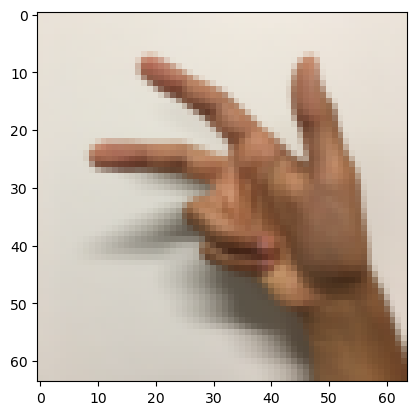

In [5]:
# Example of a picture
index = 100
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

From now implemnt your model. After that use transfer learning.
Please add cells and explain yours developing steps and your results.

استفاده از زبان فارسی برای توضیحات هم مجاز است

موفق باشید

In [26]:
import pandas as pd
from dataprep.eda import create_report
from dataprep.eda import plot_missing
from dataprep.eda import plot_correlation
from dataprep.eda import plot
import torch 
from torch import nn 
import pytorch_lightning as pl 
import torch.nn.functional as F 
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader, Subset, Dataset
from torch.optim import SGD 
from pytorch_lightning import Trainer, loggers
import numpy as np
from PIL import Image

In [24]:
# normalization constants
MEAN = torch.tensor([0.5,0.5,0.5], dtype=torch.float32)
STD = torch.tensor([0.5,0.5,0.5], dtype=torch.float32)

In [16]:
a = pd.DataFrame(Y_train_orig.T)
a.head

<bound method NDFrame.head of       0
0     5
1     0
2     2
3     5
4     2
...  ..
1075  3
1076  1
1077  2
1078  4
1079  5

[1080 rows x 1 columns]>

In [18]:
X_train_orig[index].shape

(64, 64, 3)

Training Dataset Consists of 1080 photos of 64*64*3 images in 10 classes of 426 items each

In [27]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


In [ ]:
class CNN(pl.LightningModule): 
    def __init__(self): 
        #super(model, self).__init__() 
        super().__init__()
        self.hparams['data_root'] = "data"
        self.hparams['log_dir'] = "logs"
        self.hparams['num_workers'] = 4
        self.hparams['image_size'] = 32
        self.hparams['max_epochs'] = 10
        self.hparams['batch_size'] = 64
        self.hparams['nc'] = 3
        self.hparams['nz'] = 36
        self.hparams['nfc'] = 9
        self.hparams['nfm'] = 10
        self.hparams['lr'] = 0.01
        self.hparams['gpus'] = 1
        self.hparams['validation_splitratio'] = 0.85
        self.criterion = nn.CrossEntropyLoss() 
        
        self.MLP = nn.Sequential(
            nn.Linear(self.hparams.nz, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, self.hparams.nfm) 
            )
        
        self.CNN = nn.Sequential(
            nn.Conv2d(self.hparams.nc, self.hparams.nfc, 4, 2, 1, bias=False),#nc*32*32 --> 16*16*9
            nn.ReLU(),
            nn.MaxPool2d(2, 2),#8*8*9
            nn.Conv2d(self.hparams.nfc, self.hparams.nfc * 2, 4, 2, 1, bias=False), #4*4*18
            nn.ReLU(),
            nn.MaxPool2d(2, 2),#2*2*18
            nn.Conv2d(self.hparams.nfc * 4, self.hparams.nz, 2, 1, 0, bias=False),#1*1*10,
            nn.ReLU(),
        )
        

    
    def forward(self, x): 
        batch_size, _, _, _ = x.size()
        x = self.MLP(self.CNN(x))
        return x 
    
    def configure_optimizers(self): 
        return torch.optim.SGD(self.parameters(), lr=self.hparams.lr) 

    def training_step(self, train_batch, batch_idx): 
        x, y = train_batch 
        output = self.forward(x) 
        loss = self.criterion(output, y) 
        
        logs = {"loss": loss}
        return {"loss": loss, "log": logs}
    
    def validation_step(self, valid_batch, batch_idx): 
        x, y = valid_batch 
        output = self.forward(x) 
        loss = self.criterion(output, y)
        
        logs = {"val_loss": loss}
        return {"val_loss": loss, "log": logs}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        logs = {"avg_val_loss": avg_loss}
        return {"avg_val_loss": avg_loss, "log": logs}
    
    def test_step(self, test_batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = self.criterion(output, x)

        logs = {"test_loss": loss}
        return {"test_loss": loss, "log": logs}
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        logs = {"avg_test_loss": avg_loss}
        return {"avg_test_loss": avg_loss, "log": logs}
        
    def prepare_data(self):
        transform = transforms.Compose(
            [
                transforms.Resize(self.hparams.image_size),
                transforms.CenterCrop(self.hparams.image_size),
                transforms.ToTensor(),
                transforms.Normalize(MEAN.tolist(), STD.tolist()),
            ]
        )
        #dataset = ImageFolder(root=self.hparams.data_root, transform=transform)
        dataset = MNIST(root='../input/data', download=True, transform=transform)
        
        Train_dataset = MyDataset(X_train_orig, Y_train_orig, transform=transform)
        Test_dataset = MyDataset(X_test_orig, Y_test_orig, transform=transform)


        # train, val and test split
        end_train_idx = len(dataset)*self.hparams.validation_splitratio
        end_val_idx = len(dataset)

        self.train_dataset = Subset(Train_dataset, range(0, end_train_idx))
        self.val_dataset = Subset(Train_dataset, range(end_train_idx + 1, end_val_idx))
        self.test_dataset = Test_dataset
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True, num_workers=self.hparams.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers
        )

In [ ]:
clf = CNN()
logger = loggers.TensorBoardLogger(model.hparams.log_dir, name=f"bs{model.hparams.batch_size}_nf{model.hparams.nfe}")

# print detailed summary with estimated network size
summary(clf, (clf.hparams.nc, clf.hparams.image_size, clf.hparams.image_size), device="cpu")

trainer = Trainer(logger=logger, accelerator='cuda', devices=model.hparams.gpus, max_epochs=model.hparams.max_epochs)
trainer.fit(clf)

In [ ]:
torch.save(clf.state_dict(), 'outputs/CNN.pth')

In [ ]:
trainer.test(clf)

#Load Saved Model

In [ ]:
clf = CNN()
clf.load_state_dict(torch.load('outputs/CNN.pth', map_location=torch.device('cuda')))
clf.eval()